In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from modeling_gemma import KVCache
from processing_paligemma import PaliGemmaProcessor, LabelProcessor
from prepare_data import *
from utils import *

# print(f"Loading data")
# with open('data/fashion-dataset/training_set.pkl', 'rb') as f:
#     training_set = pickle.load(f)
# training_set.shuffle(1)
# with open('data/fashion-dataset/validation_set.pkl', 'rb') as f:
#     validation_set = pickle.load(f)
# with open('data/fashion-dataset/testing_set.pkl', 'rb') as f:
#     testing_set = pickle.load(f)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = 'cpu'
print("Device in use: ", device)
model_path = 'paligemma'

Device in use:  cuda


In [2]:
print(f"Loading model")
tokenizer_modified = True
rank = 16  # LoRA rank
# rank = 32  # LoRA rank

model, tokenizer = load_hf_model(model_path, device, 0)
model = apply_lora(model, device, rank=rank)
model = model.half()
model = model.to(device).eval()
vocab_size = len(tokenizer)

Loading model
Applying LoRA


In [3]:
vocab_size = 262875
update_embeddings(model, model.vocab_size, vocab_size, device)
num_image_tokens = model.config.vision_config.num_image_tokens
image_size = model.config.vision_config.image_size
processor = PaliGemmaProcessor(tokenizer, num_image_tokens, (image_size, image_size))
label_processor = LabelProcessor(tokenizer)
max_tokens_to_generate = 100
temperature = 0.8
top_p = 0.9
do_sample = False
stop_token = processor.tokenizer.eos_token_id

Update embeddings


In [4]:
checkpoint = 'my_model/1/model_2025-01-05_rank16_epoch_48_.pth'
model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

In [7]:
torch.quantization.prepare(model, inplace=True)
image_paths, prompts, label_words, images, _, _, _ = validation_set[0]
images = [np.squeeze(images[:, :, :, i]) for i in range(images.shape[3])]
model_inputs = processor(prompts, images)
model_inputs = move_inputs_to_device(model_inputs, device)
input_ids = model_inputs['input_ids'].to(device)
attention_mask = model_inputs['attention_mask'].to(device)
pixel_values = model_inputs['pixel_values'].half().to(device)
kv_cache = KVCache()

model(input_ids=input_ids,
      pixel_values=pixel_values,
      attention_mask=attention_mask,
      kv_cache=kv_cache,
      )

D:\Anaconda\envs\He\lib\site-packages\torch\ao\quantization\quantize.py:312: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


PaliGemmaForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(256, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (self_attn): SiglipAttention(
              (k_proj): ParametrizedLinear(
                in_features=1152, out_features=1152, bias=True
                (parametrizations): ModuleDict(
                  (weight): ParametrizationList(
                    (0): LoRAParametrization()
                  )
                )
              )
              (q_proj): ParametrizedLinear(
                in_features=1152, out_features=1152, bias=True
                (parametrizations): ModuleDict(
                  (weight): ParametrizationList(
                    (0): Lo

In [9]:
image_paths, prompts, label_words, images, _, _, _ = validation_set[0]
images = [np.squeeze(images[:, :, :, i]) for i in range(images.shape[3])]
model_inputs = processor(prompts, images)
model_inputs = move_inputs_to_device(model_inputs, device)
input_ids = model_inputs['input_ids'].to(device)
attention_mask = model_inputs['attention_mask'].to(device)
pixel_values = model_inputs['pixel_values'].half().to(device)
kv_cache = KVCache()

model(input_ids=input_ids,
      pixel_values=pixel_values,
      attention_mask=attention_mask,
      kv_cache=kv_cache,
      )

({'logits': tensor([[[ 20.6719,   4.1406, -12.7656,  ...,  -7.2070, -13.3750,   0.3635],
           [ 20.5312,   3.9824, -13.0234,  ...,  -7.4766, -13.5391,   0.5430],
           [ 20.6094,   4.0938, -12.8203,  ...,  -7.3281, -13.5547,   0.4094],
           ...,
           [ 26.5156,   0.9512,  -6.7539,  ...,  -6.1719,  -9.6562,   3.1035],
           [ 26.5156,   0.9512,  -6.7539,  ...,  -6.1719,  -9.6562,   3.1035],
           [ 26.5156,   0.9512,  -6.7539,  ...,  -6.1719,  -9.6562,   3.1035]]],
         device='cuda:0', grad_fn=<ToCopyBackward0>),
  'kv_cache': <modeling_gemma.KVCache at 0x278629df040>},
 [tensor([[[[8.2254e-06, 9.7156e-06, 7.9274e-06,  ..., 1.2624e-04,
             8.7023e-06, 8.7619e-06],
            [9.0599e-06, 1.0788e-05, 8.7619e-06,  ..., 1.4210e-04,
             9.6560e-06, 9.7752e-06],
            [8.1658e-06, 9.6560e-06, 7.8678e-06,  ..., 1.2565e-04,
             8.7023e-06, 8.7619e-06],
            ...,
            [3.8505e-05, 4.6611e-05, 3.7014e-05,  ...,

In [10]:
torch.quantization.convert(model, inplace=True)

PaliGemmaForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(256, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (self_attn): SiglipAttention(
              (k_proj): ParametrizedLinear(
                in_features=1152, out_features=1152, bias=True
                (parametrizations): ModuleDict(
                  (weight): ParametrizationList(
                    (0): LoRAParametrization()
                  )
                )
              )
              (q_proj): ParametrizedLinear(
                in_features=1152, out_features=1152, bias=True
                (parametrizations): ModuleDict(
                  (weight): ParametrizationList(
                    (0): Lo

AssertionError: nn.quantized.dynamic.Linear.from_float only works for one of['Linear', 'NonDynamicallyQuantizableLinear', 'LinearReLU', 'Linear']

In [11]:
torch.save(model.state_dict(), 'my_model/1/model_2025-01-05_rank16_epoch_48_Q.pth')

In [5]:
validation_set = prepare_dataset(training=0, validation=1, augment=False)

# print(f"Loading data")
# with open('data/fashion-dataset/validation_set.pkl', 'rb') as f:
#     validation_set = pickle.load(f)

Viewing the set into batch_size=4


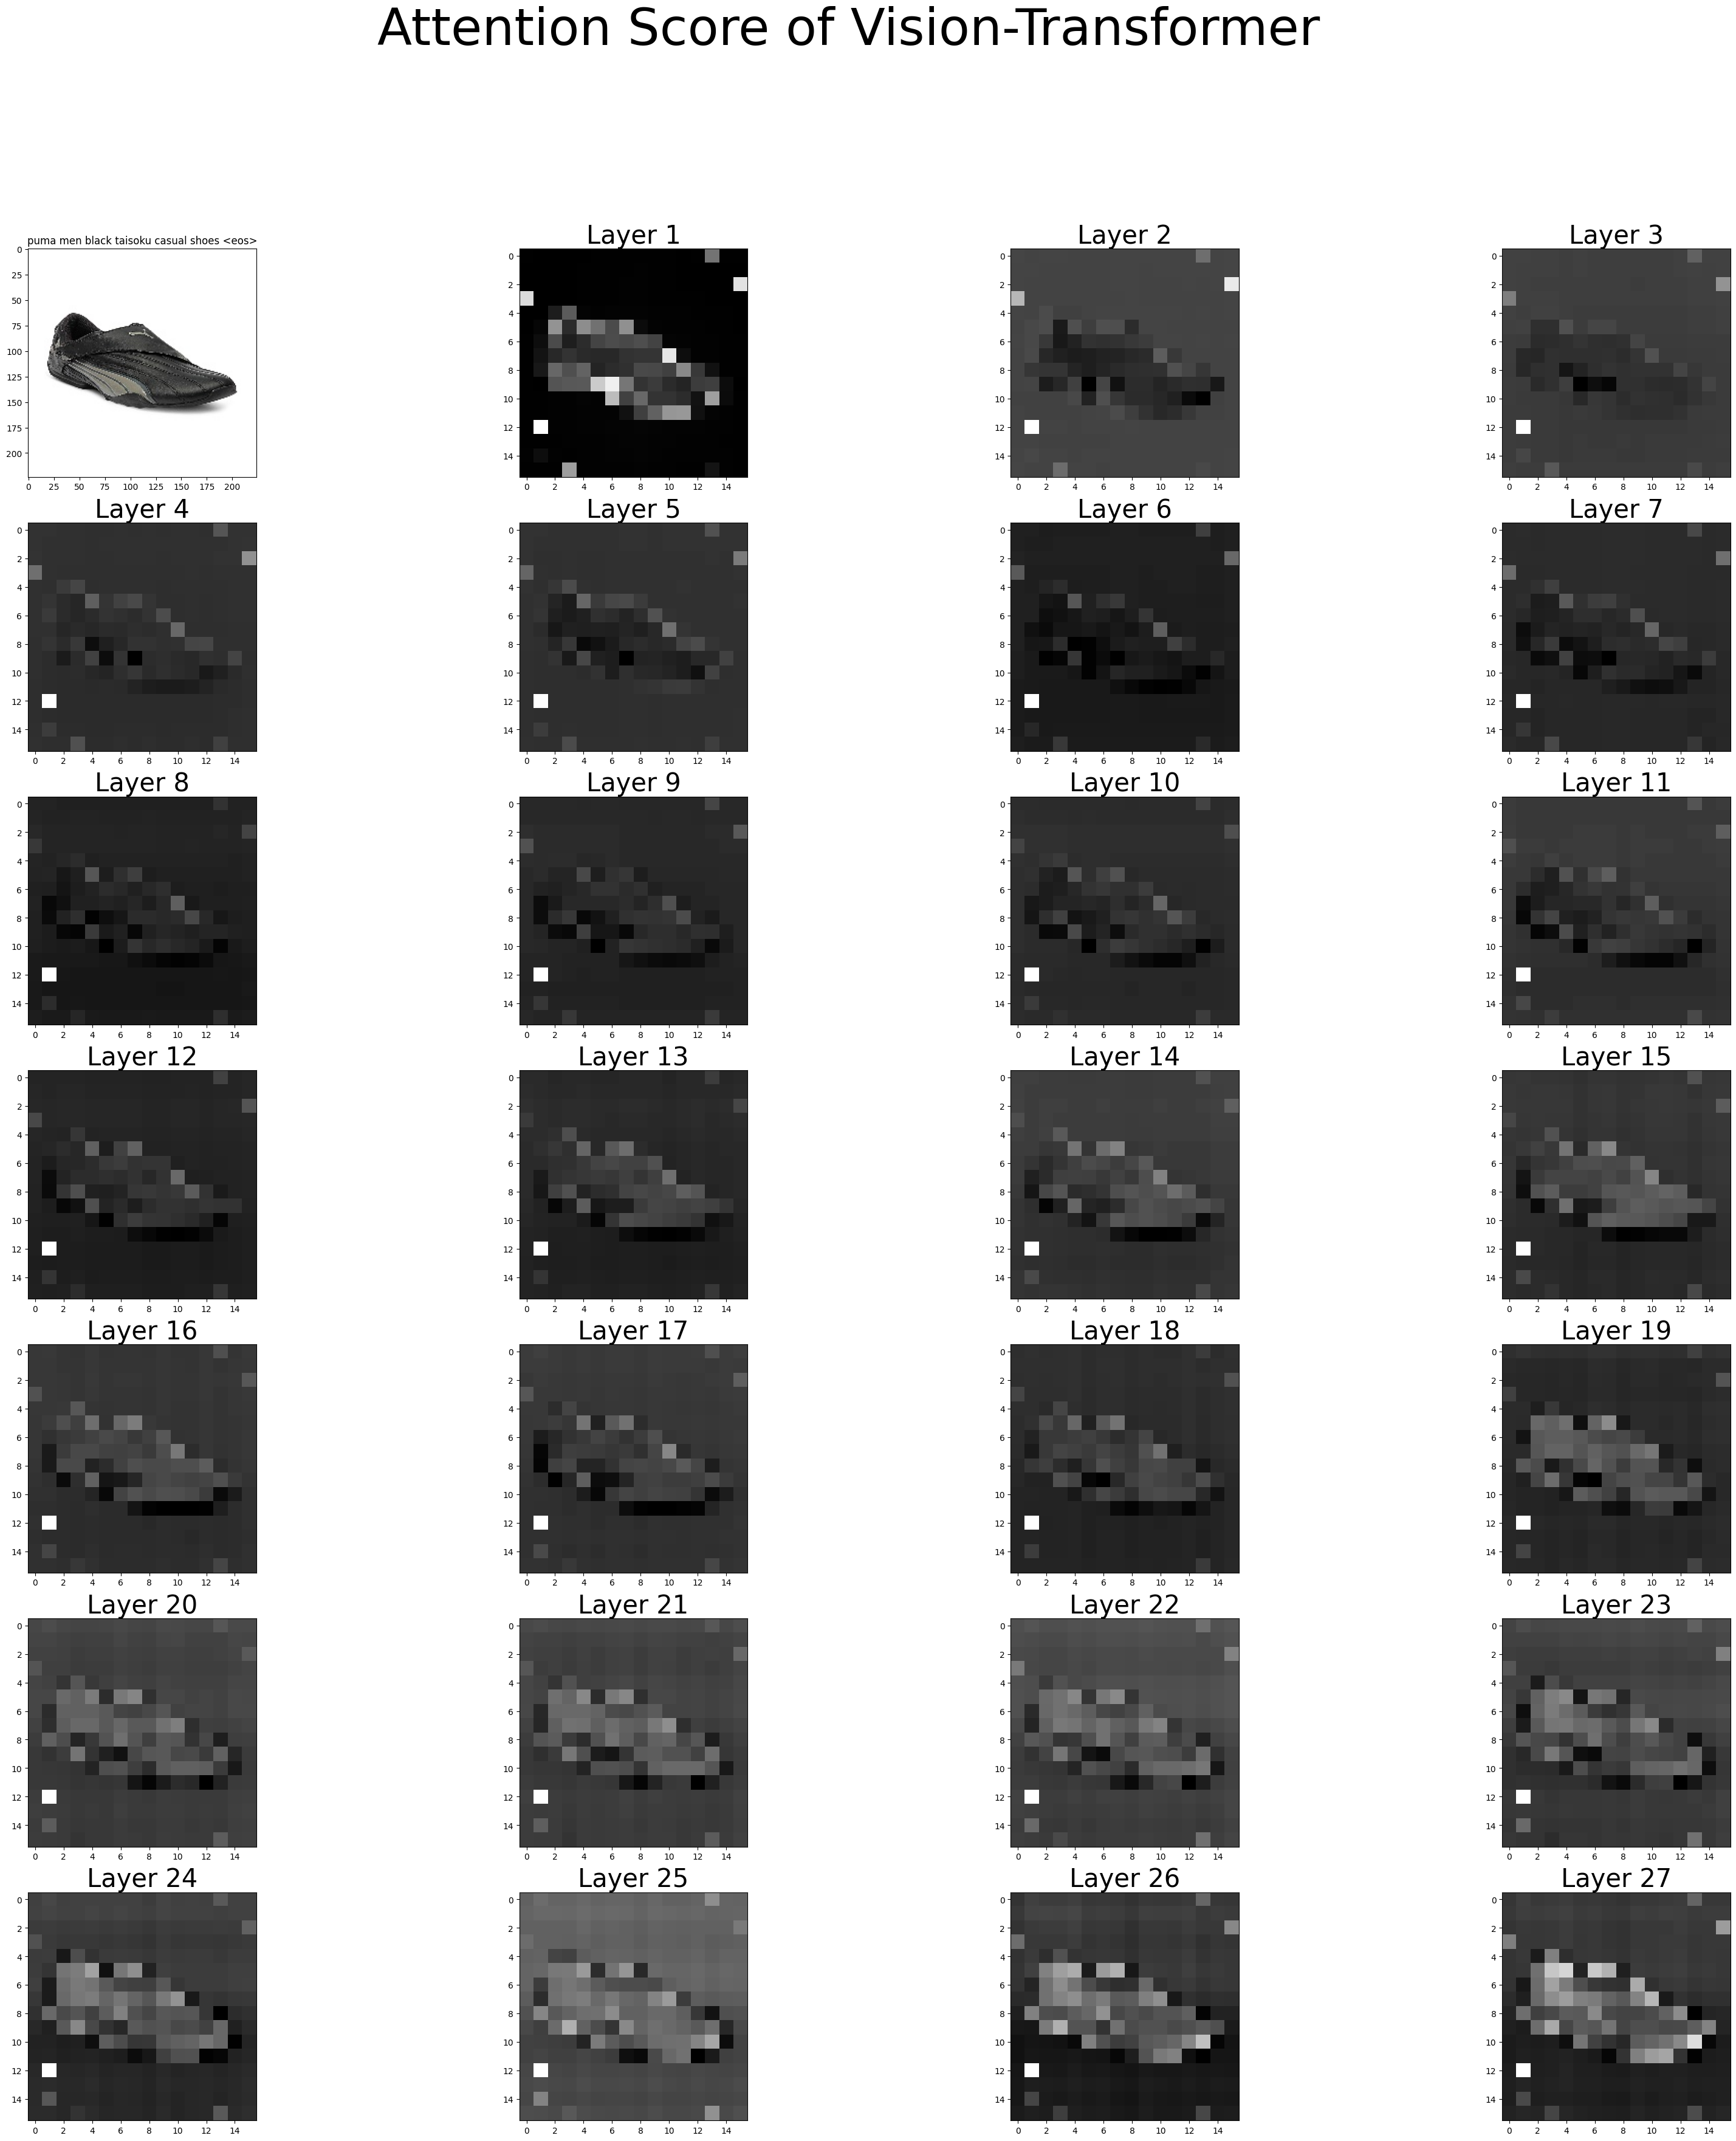

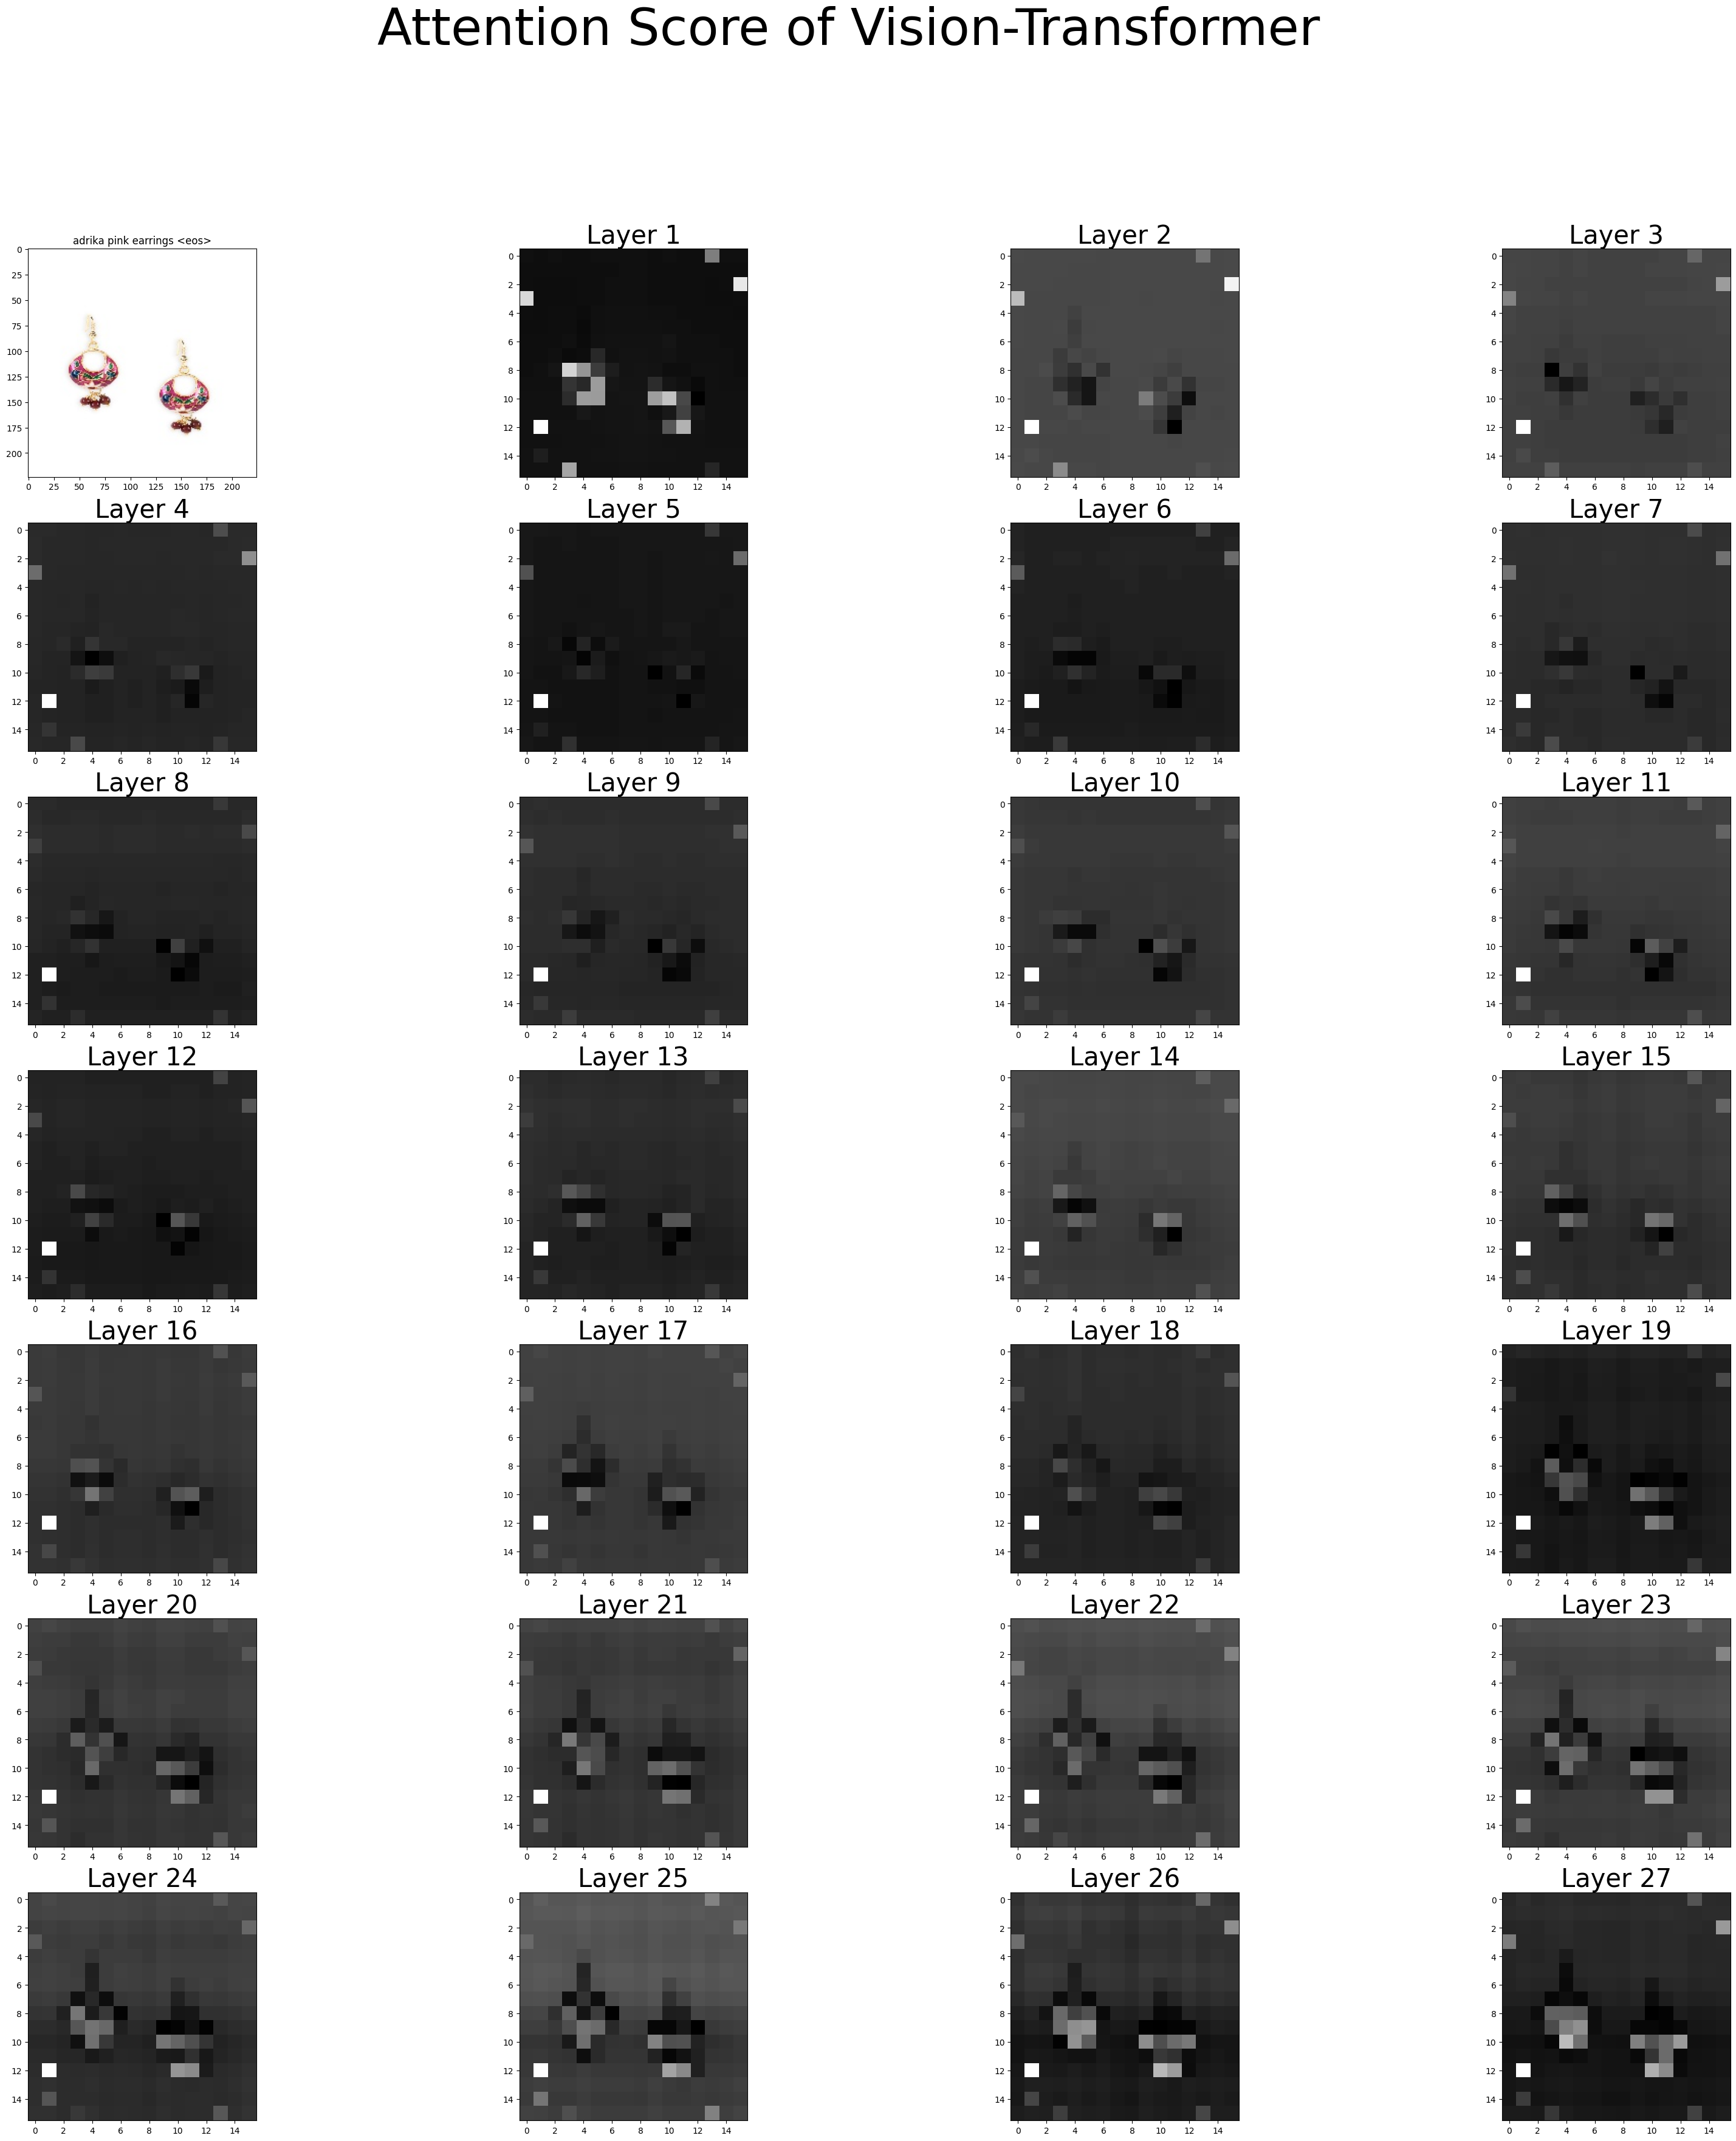

KeyboardInterrupt: 

In [6]:
'''
VisionTransformer注意力分数可视化
'''
print('Start validating:')
# device = 'cpu'
# model = model.to(device)
color_correct = 0
total_num_color = 0
pred_colors = []
true_colors = []
validation_set.shuffle(1)
with torch.no_grad():
    for i, (image_paths, prompts, label_words, images, _, _, _) in enumerate(validation_set):
        images = [np.squeeze(images[:, :, :, i]) for i in range(images.shape[3])]
        model_inputs = processor(prompts, images)
        model_inputs = move_inputs_to_device(model_inputs, device)
        input_ids = model_inputs['input_ids'].to(device)
        attention_mask = model_inputs['attention_mask'].to(device)
        pixel_values = model_inputs['pixel_values'].half().to(device)
        #         pixel_values = model_inputs['pixel_values'].to(device)

        kv_cache = KVCache()
        labels_ids, labels_attention_mask, total_num = get_ids(tokenizer, label_words)
        labels_ids = labels_ids.to(device)
        labels_attention_mask = labels_attention_mask.to(device)
        generated_words = ''
        loss_list_sample = []
        correct_num = 0
        attn_score_list = []
        for j in range(max_tokens_to_generate):
            if j >= labels_ids.shape[1]:
                break
            outputs, attention_weight_list, _ = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
                kv_cache=kv_cache,
            )
            kv_cache = outputs["kv_cache"]
            if j == 0:
                for attn_weight in attention_weight_list:
                    attn_score_list.append(np.resize(torch.sum(attn_weight, 1)[0].sum(axis=0).cpu(), (16, 16)))

            pred_ids = outputs["logits"][:, -1, :].argmax(1)
            pred_word = tokenizer.decode(pred_ids)
            generated_words += f'{pred_word} '
            pred_ids = torch.unsqueeze(pred_ids, 0)
            input_ids = pred_ids
            attention_mask = torch.cat([attention_mask, (pred_ids != 0).int()], dim=-1).detach().to(
                device)  # 更新attention_mask，若batch中的某一条样本已经输入完，则mask对应的位置为0，否则为1

            pred_ids = torch.softmax(outputs["logits"][:, -1, :], dim=-1, dtype=torch.float16).argmax(1)
            if pred_ids == stop_token:
                break
        fig, ax = plt.subplots(7, 4, figsize=(40, 40))
        # fig.tight_layout()
        disp_image = plt.imread(image_paths[0])
        ax[0][0].imshow(disp_image)
        ax[0][0].imshow(images[0][:, :, [2, 1, 0]])
        ax[0][0].title.set_text(label_words[0])
        for l, attn_score in enumerate(attn_score_list):
            r = (l + 1) // 4
            c = l + 1 - r * 4
            attn_score = np.log2(attn_score + 1)
            attn_score = (attn_score / attn_score.max() * 255).astype(np.uint8)
            ax[r][c].imshow(attn_score, cmap='gray')
            ax[r][c].set_title(f'Layer {l + 1}', fontsize=30)
        fig.suptitle('Attention Score of Vision-Transformer', fontsize=60)
        plt.show()
        input(f'{i}\n\t{label_words[0]}\n\t{generated_words}')

In [9]:
labels_ids.shape

torch.Size([1, 6, 1])

In [ ]:
'''
Gemma语言模型注意力分数可视化（第一层Attention）
'''
print('Start validating:')
color_correct = 0
total_num_color = 0
pred_colors = []
true_colors = []
validation_set.shuffle(1)
with torch.no_grad():
    for i, (image_paths, prompts, label_words, images, _, _, _) in enumerate(validation_set):
        images = [np.squeeze(images[:, :, :, i]) for i in range(images.shape[3])]
        model_inputs = processor(prompts, images)
        model_inputs = move_inputs_to_device(model_inputs, device)
        input_ids = model_inputs['input_ids'].to(device)
        attention_mask = model_inputs['attention_mask'].to(device)
        pixel_values = model_inputs['pixel_values'].half().to(device)
        #         pixel_values = model_inputs['pixel_values'].to(device)

        kv_cache = KVCache()
        labels_ids, labels_attention_mask, total_num = get_ids(tokenizer, label_words)
        labels_ids = labels_ids.to(device)
        labels_attention_mask = labels_attention_mask.to(device)
        generated_words = ''
        loss_list_sample = []
        correct_num = 0
        attn_score_list = []
        label_list = label_words[0].split(' ')

        fig, ax = plt.subplots(7, 4, figsize=(40, 40))
        ax[0][0].imshow(images[0][:, :, [2, 1, 0]])
        ax[0][0].title.set_text(label_words[0])
        for j in range(max_tokens_to_generate):
            outputs, attention_weight_list, gemma_attention_weight = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
                kv_cache=kv_cache,
            )
            kv_cache = outputs["kv_cache"]
            pred_ids = outputs["logits"][:, -1, :].argmax(1)
            pred_word = tokenizer.decode(pred_ids)
            generated_words += f'{pred_word} '
            pred_ids = torch.unsqueeze(pred_ids, 0)
            input_ids = pred_ids
            attention_mask = torch.cat([attention_mask, (pred_ids != 0).int()], dim=-1).detach().to(
                device)  # 更新attention_mask，若batch中的某一条样本已经输入完，则mask对应的位置为0，否则为1
            pred_ids = torch.softmax(outputs["logits"][:, -1, :], dim=-1, dtype=torch.float16).argmax(1)

            gemma_attention_weight = torch.sum(gemma_attention_weight, dim=1)[0].cpu().numpy()
            gemma_attention_weight = gemma_attention_weight[256 + j, :256] if j == 0 else gemma_attention_weight[0,
                                                                                          :256]
            gemma_attention_matrix = gemma_attention_matrix = np.reshape(gemma_attention_weight, (16, 16))
            gemma_attention_matrix = np.log2(gemma_attention_matrix + 1)
            gemma_attention_matrix = gemma_attention_matrix - gemma_attention_matrix.min()
            gemma_attention_matrix = (gemma_attention_matrix / gemma_attention_matrix.max() * 255).astype(np.uint8)
            r = (j + 1) // 4
            c = j + 1 - r * 4
            ax[r][c].imshow(gemma_attention_matrix, cmap='gray')
            ax[r][c].set_title(f"{pred_word}/{label_list[j] if j <= len(label_list) - 1 else ' '}", fontsize=30)

            if pred_ids == stop_token:
                break
        fig.suptitle('Attention Score of Gemma', fontsize=60)
        plt.show()
        input(f'{i}\n\t{label_words[0]}\n\t{generated_words}')

In [81]:
gemma_attention_weight = torch.sum(gemma_attention_weight, dim=1)[0].shape

torch.Size([284, 284])

In [83]:
gemma_attention_weight = torch.sum(gemma_attention_weight, dim=1)[0]

In [115]:
gemma_attention_weight.shape

torch.Size([1, 285])

In [82]:
label_words

['french connection women black handbag <eos>']